In [17]:
import nanonets
import matplotlib.pyplot as plt
import matplotlib as mpl
import scienceplots
import numpy as np
import pandas as pd
import networkx as nx

%matplotlib inline

from scipy.optimize import curve_fit
from scipy.special import gamma
from matplotlib.colors import Normalize, LogNorm
from matplotlib.cm import ScalarMappable
plt.style.use(["science","bright","grid"])
cm  = plt.get_cmap('cividis')

In [18]:
def self_capacitance_sphere(np_radius):
    e0      = 8.85418781762039e-3
    eps_s   = 3.9
    factor  = 4 * np.pi * e0 * eps_s
    cap     = factor * np_radius
    return cap

### 2 Electrode Setup

In [19]:
def shift_and_append(dfs_dict):
    for name, df in dfs_dict.items():
        col1 = df.pop("1")
        df.columns = range(df.shape[1])
        df[len(df.columns)] = col1
    return dfs_dict

folder      = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/potential/magic_cable/dc_input_vs_cap/"
# folder      = "/home/j/j_mens07/phd/data/2_funding_period/potential/magic_cable/dc_input_vs_cap/"
U_0         = 0.02
N_voltages  = 200000
t_vals      = np.arange(N_voltages-1)*1e-10*1e9
cap_vals    = [1e0,5e0,1e1,5e1,1e2,5e2,1e3,5e3,1e4,5e4,1e5,5e5,1e6]
data_cap    = {cap : pd.read_csv(f"{folder}Nx=9_Ny=9_Ne=2_{cap}.csv") for cap in cap_vals}
pot_cap     = {cap : pd.read_csv(f"{folder}mean_state_Nx=9_Ny=9_Ne=2_{cap}.csv") for cap in cap_vals}
pot_cap     = shift_and_append(pot_cap)

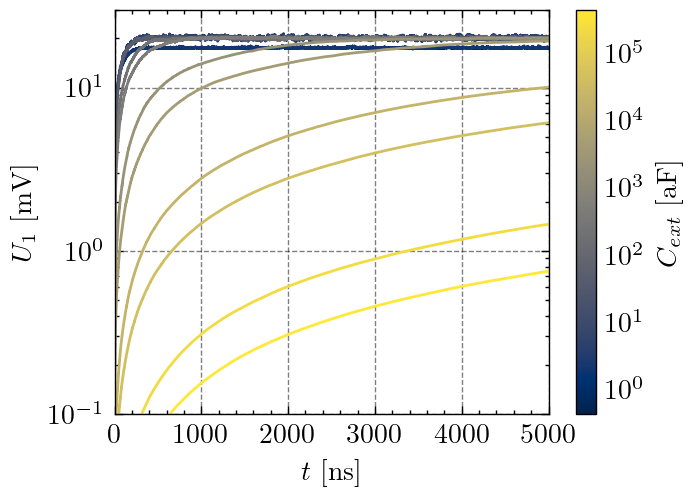

In [24]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = LogNorm(vmin=min(self_capacitance_sphere(np.array(cap_vals))), vmax=max(self_capacitance_sphere(np.array(cap_vals))))

for i, (key, df) in enumerate(data_cap.items()):

    y   = df['Observable']*1000
    y_e = df['Error']*1000
    ax.plot(t_vals, y, color=cm(norm(self_capacitance_sphere(key))))
    # ax.fill_between(t_vals, y+y_e, y-y_e, alpha=0.5, color='black')

ax.set_yscale('log')
ax.set_ylim(0.1,3e1)
ax.set_xlim(0,5000)
ax.set_ylabel('$U_1$ [mV]')
ax.set_xlabel('$t$ [ns]')

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$C_{ext}$ [aF]")

fig.savefig("../plots/dc_input/2_electrodes/output_response.svg", transparent=True)

In [25]:
p_vals, cov_vals = [], []
p0_vals = [0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.8,0.7,0.6,0.5]
p0, p1 = 0.2, 0.995
for i, cap in enumerate(cap_vals):
    x   = t_vals.copy()
    y   = data_cap[cap].loc[:,'Observable'].values
    def func(t, tau, a0):
        return U_0 - a0*np.exp(-t/tau)
        
    t0      = np.argmax(y>p0*U_0)
    t1      = np.argmax(y>p1*U_0)
    x_fit   = x.copy()[t0:]
    y_fit   = y.copy()[t0:]
    p, cov  = curve_fit(func, x_fit, y_fit, p0=[cap,U_0], bounds=((0,0),(np.inf,np.inf)))

    p_vals.append(p)
    cov_vals.append(cov)

taus = np.array(p_vals)[:,0]

In [26]:
# Convert capacitance values 
cap_vals_t  = np.array(cap_vals).copy()
cap_vals_t  = np.round(self_capacitance_sphere(np.array(cap_vals)))

# Only use points from index 5 onward
cap_subset = cap_vals_t[5:]
tau_subset = taus[5:]

# Fit in log-log spac
log_cap     = np.log(cap_subset)
log_tau     = np.log(tau_subset)
B, log_A    = np.polyfit(log_cap, log_tau, 1)
A           = np.exp(log_A)

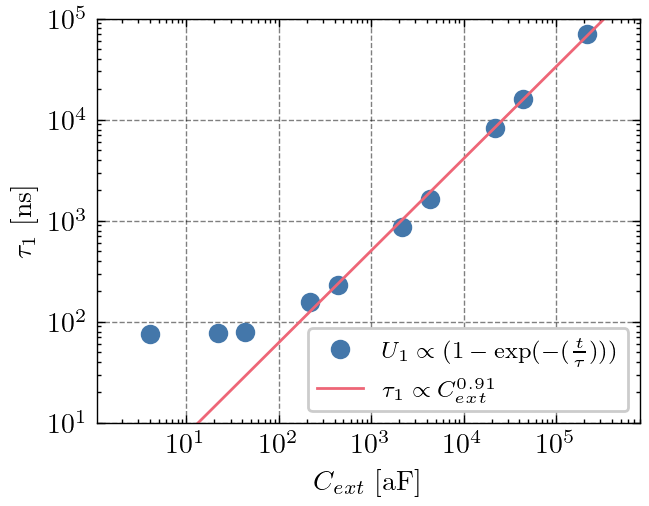

In [27]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(cap_vals_t, taus, 'o', label='$U_1 \propto (1-\exp({-(\\frac{t}{\\tau})}))$')
ax.plot(cap_vals_t, A * cap_vals_t**np.round(B,2), label='$\\tau_1 \propto C_{ext}^{'+f'{np.round(B,2)}'+'}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize='small')
ax.set_ylabel('$\\tau_1$ [ns]')
ax.set_xlabel('$C_{ext}$ [aF]')
ax.set_ylim(1e1,1e5)
fig.savefig("../plots/dc_input/2_electrodes/tau_vs_cap.svg", transparent=True)

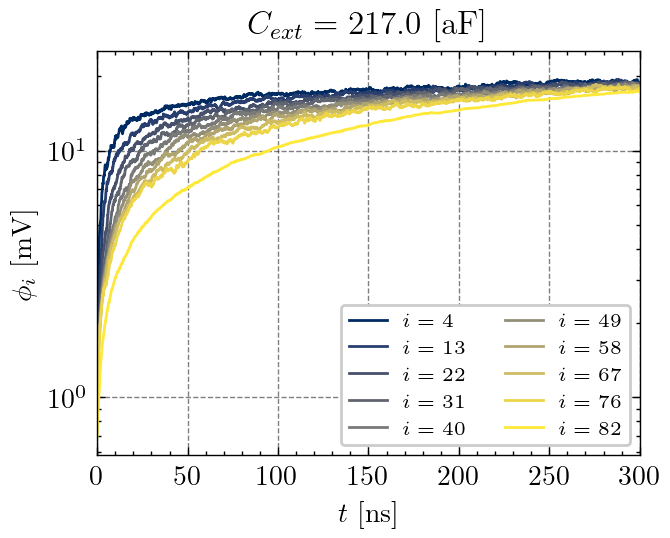

In [28]:
cap     = 500.0
np_idx  = [9*i+4 for i in range(0,9)] + [82]
pot_arr = pot_cap[cap].loc[:,np_idx].values
norm    = Normalize(vmin=0, vmax=82)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
for i in range(pot_arr.shape[1]):
    ax.plot(t_vals, pot_arr[:,i]*1000, color=cm(norm(np_idx[i])), label=f'$i = {np_idx[i]}$')
ax.set_xlim(0,300)
ax.set_ylabel('$\phi_i$ [mV]')
ax.set_xlabel('$t$ [ns]')
ax.set_title("$C_{ext} = "+f"{np.round(self_capacitance_sphere(cap))}$ [aF]")
ax.set_yscale('log')
ax.legend(ncol=2, fontsize='x-small')
fig.savefig("../plots/dc_input/2_electrodes/potentials_along_the_line.svg", transparent=True)

### 8 Electrodes

In [29]:
def shift_and_append(dfs_dict):
    for name, df in dfs_dict.items():
        col1 = df.pop("1")
        df.columns = range(df.shape[1])
        df[len(df.columns)] = col1
    return dfs_dict

def drop_columns(dfs_dict):
    for name, df in dfs_dict.items():
        df = df.drop(columns=[1,2,3,4,5,6])
        df.columns = range(df.shape[1])
        dfs_dict[name] = df
    return dfs_dict

folder      = "/mnt/c/Users/jonas/Desktop/phd/data/2_funding_period/potential/magic_cable/dc_input_vs_cap/"
# folder      = "/home/j/j_mens07/phd/data/2_funding_period/potential/magic_cable/dc_input_vs_cap/"
U_0         = 0.02
N_voltages  = 200000
t_vals      = np.arange(N_voltages-1)*1e-10*1e9
cap_vals    = [1e0,5e0,1e1,5e1,1e2,5e2,1e3,5e3,1e4,5e4,1e5,5e5,1e6]
data_cap    = {cap : pd.read_csv(f"{folder}Nx=9_Ny=9_Ne=8_{cap}.csv") for cap in cap_vals}
pot_cap     = {cap : pd.read_csv(f"{folder}mean_state_Nx=9_Ny=9_Ne=8_{cap}.csv") for cap in cap_vals}
pot_cap     = shift_and_append(pot_cap)
pot_cap     = drop_columns(pot_cap)

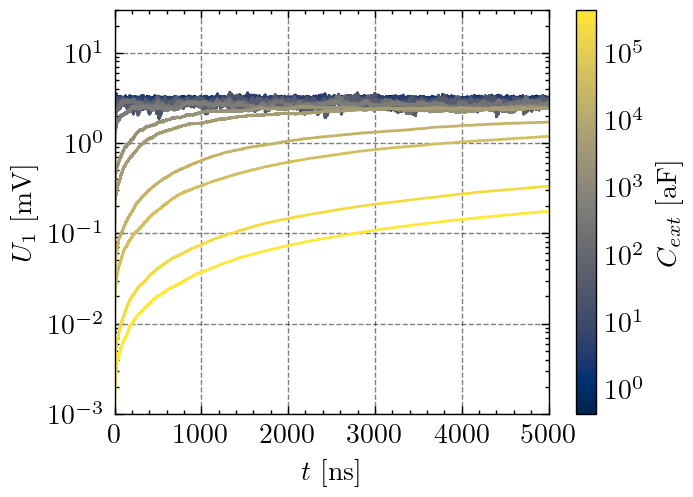

In [31]:
fig     = plt.figure(dpi=200)
ax      = fig.add_subplot()
norm    = LogNorm(vmin=min(self_capacitance_sphere(np.array(cap_vals))), vmax=max(self_capacitance_sphere(np.array(cap_vals))))

for i, (key, df) in enumerate(data_cap.items()):

    y   = df['Observable']*1000
    y_e = df['Error']*1000
    ax.plot(t_vals, y, color=cm(norm(self_capacitance_sphere(key))))
    # ax.fill_between(t_vals, y+y_e, y-y_e, alpha=0.5, color='black')

ax.set_yscale('log')
ax.set_ylim(0.001,3e1)
ax.set_xlim(0,5000)
ax.set_ylabel('$U_1$ [mV]')
ax.set_xlabel('$t$ [ns]')

sm  = ScalarMappable(cmap=cm, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("$C_{ext}$ [aF]")

fig.savefig("../plots/dc_input/8_electrodes/output_response.svg", transparent=True)

In [47]:
p_vals, cov_vals = [], []
p0, p1 = 0.2, 0.995
for i, cap in enumerate(cap_vals):
    x   = t_vals.copy()
    y   = data_cap[cap].loc[:,'Observable'].values
    ym  = np.mean(y[-1000:])
    def func(t, tau, a0):
        return a0*(1-np.exp(-t/tau))
        
    t0      = np.argmax(y>p0*ym)
    t1      = np.argmax(y>p1*ym)
    x_fit   = x.copy()[t0:]
    y_fit   = y.copy()[t0:]
    p, cov  = curve_fit(func, x_fit, y_fit, p0=[cap,U_0], bounds=((0,0),(np.inf,np.inf)))

    p_vals.append(p)
    cov_vals.append(cov)

taus = np.array(p_vals)[:,0]

In [48]:
# Convert capacitance values 
cap_vals_t  = np.array(cap_vals).copy()
cap_vals_t  = np.round(self_capacitance_sphere(np.array(cap_vals)))

# Only use points from index 5 onward
cap_subset = cap_vals_t[5:]
tau_subset = taus[5:]

# Fit in log-log spac
log_cap     = np.log(cap_subset)
log_tau     = np.log(tau_subset)
B, log_A    = np.polyfit(log_cap, log_tau, 1)
A           = np.exp(log_A)

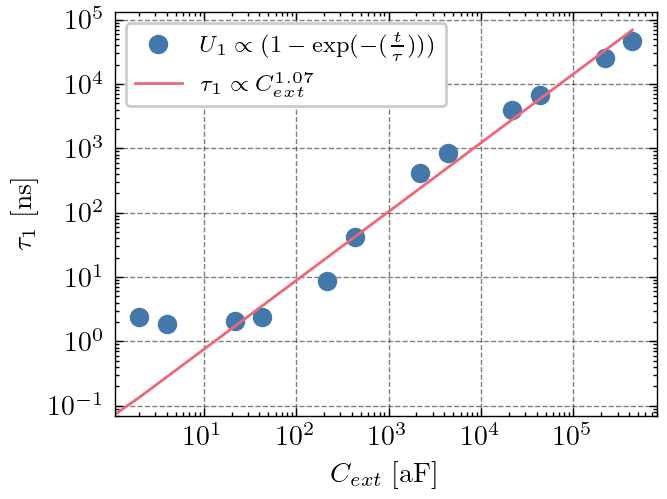

In [49]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(cap_vals_t, taus, 'o', label='$U_1 \propto (1-\exp({-(\\frac{t}{\\tau})}))$')
ax.plot(cap_vals_t, A * cap_vals_t**np.round(B,2), label='$\\tau_1 \propto C_{ext}^{'+f'{np.round(B,2)}'+'}$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(fontsize='small')
ax.set_ylabel('$\\tau_1$ [ns]')
ax.set_xlabel('$C_{ext}$ [aF]')
# ax.set_ylim(1e1,1e5)
fig.savefig("../plots/dc_input/8_electrodes/tau_vs_cap.svg", transparent=True)

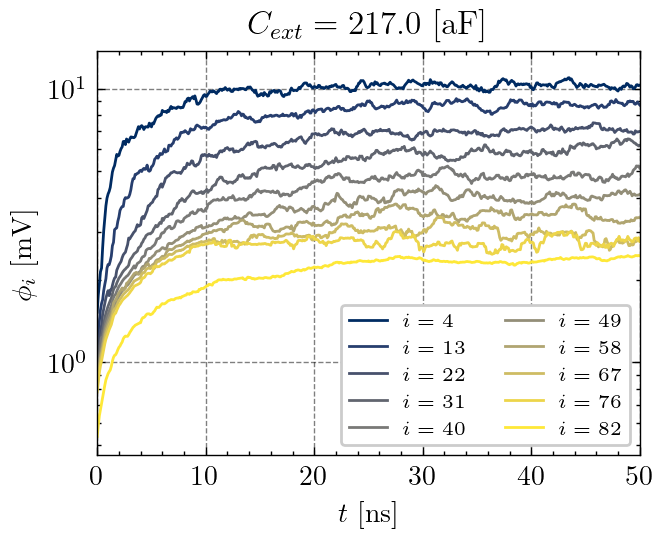

In [50]:
cap     = 500.0
np_idx  = [9*i+4 for i in range(0,9)] + [82]
pot_arr = pot_cap[cap].loc[:,np_idx].values
norm    = Normalize(vmin=0, vmax=82)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
for i in range(pot_arr.shape[1]):
    ax.plot(t_vals, pot_arr[:,i]*1000, color=cm(norm(np_idx[i])), label=f'$i = {np_idx[i]}$')
ax.set_xlim(0,50)
ax.set_ylabel('$\phi_i$ [mV]')
ax.set_xlabel('$t$ [ns]')
ax.set_title("$C_{ext} = "+f"{np.round(self_capacitance_sphere(cap))}$ [aF]")
ax.set_yscale('log')
ax.legend(ncol=2, fontsize='x-small')
fig.savefig("../plots/dc_input/8_electrodes/potentials_along_the_line.svg", transparent=True)